<a href="https://colab.research.google.com/github/JuliusR8ll/Complete-Feature-Selection/blob/master/HAM10000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
import seaborn as sns

In [2]:
!nvidia-smi

Thu Feb  2 06:14:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
skin_df = pd.read_csv('/content/drive/MyDrive/HAM10000/HAM10000_metadata.csv')


In [5]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/drive/MyDrive/HAM10000/', '*', '*.jpg'))}

In [6]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)

In [7]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))

In [8]:
print(skin_df['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


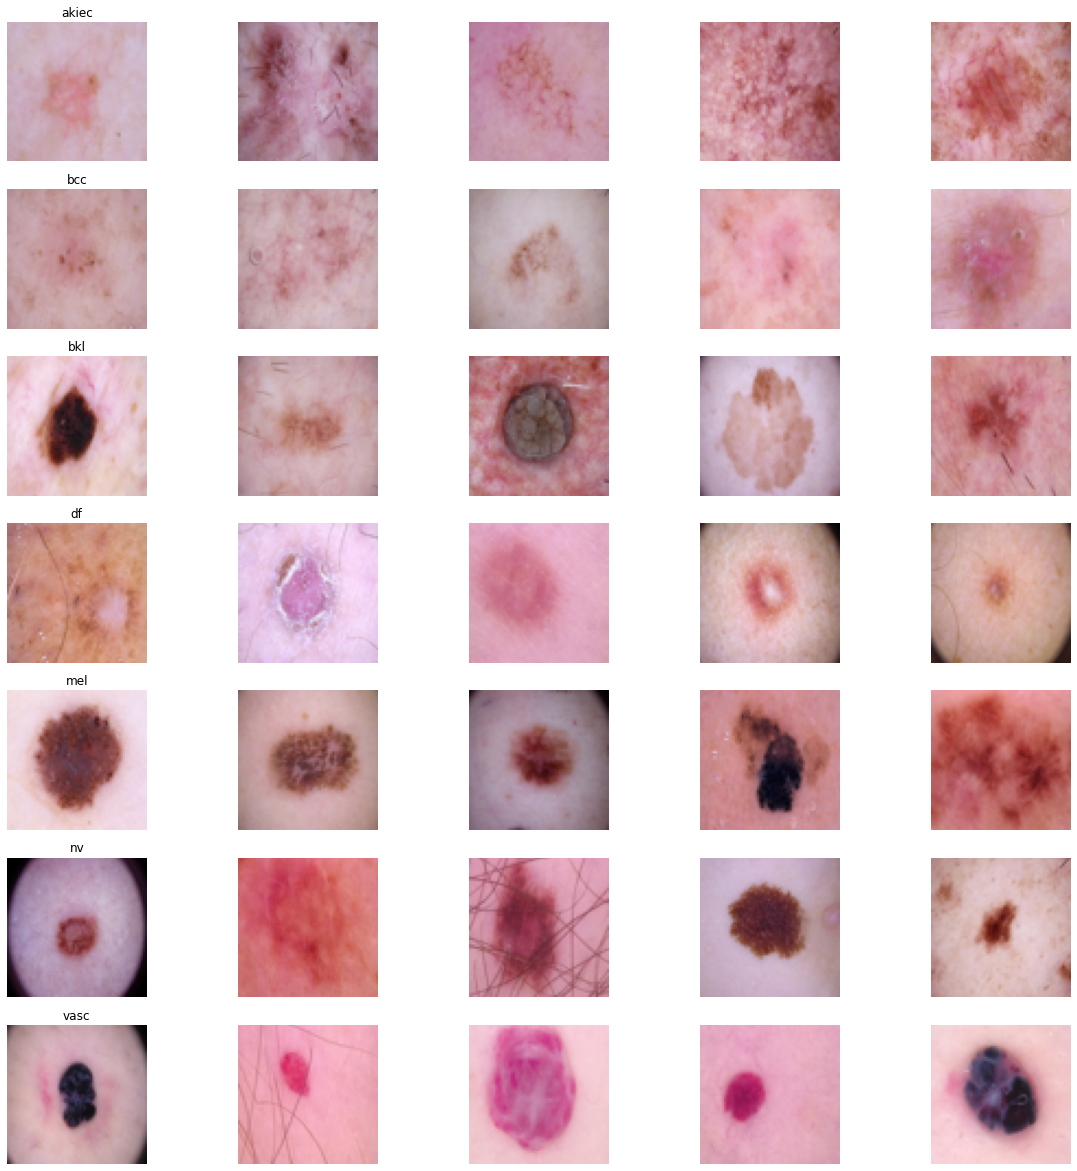

In [9]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [10]:
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [11]:
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [12]:
skin_df['label'] = le.transform(skin_df["dx"]) 

In [13]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [14]:
X = np.asarray(skin_df['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42,stratify=skin_df.label.values)

In [15]:
from tensorflow import keras
from tensorflow_hub import KerasLayer

In [16]:
model = Sequential()


In [17]:
# model.add(KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5",
#                trainable=True, arguments=dict(batch_norm_momentum=0.997)))

In [18]:
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(64, 64, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

In [19]:
model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))


In [20]:
model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

In [21]:
model.add(Dense(32))
model.add(Dense(7, activation='softmax'))

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [23]:
batch_size = 32 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/50
235/235 - 15s - loss: 1.0380 - acc: 0.6682 - val_loss: 1.1654 - val_acc: 0.6689 - 15s/epoch - 64ms/step
Epoch 2/50
235/235 - 5s - loss: 0.9507 - acc: 0.6709 - val_loss: 0.9388 - val_acc: 0.6729 - 5s/epoch - 23ms/step
Epoch 3/50
235/235 - 6s - loss: 0.9213 - acc: 0.6746 - val_loss: 0.9126 - val_acc: 0.6937 - 6s/epoch - 25ms/step
Epoch 4/50
235/235 - 6s - loss: 0.8911 - acc: 0.6799 - val_loss: 0.9340 - val_acc: 0.6869 - 6s/epoch - 25ms/step
Epoch 5/50
235/235 - 6s - loss: 0.8606 - acc: 0.6894 - val_loss: 0.8548 - val_acc: 0.7053 - 6s/epoch - 25ms/step
Epoch 6/50
235/235 - 6s - loss: 0.8181 - acc: 0.7016 - val_loss: 0.8363 - val_acc: 0.6885 - 6s/epoch - 25ms/step
Epoch 7/50
235/235 - 5s - loss: 0.8176 - acc: 0.7044 - val_loss: 0.8432 - val_acc: 0.7021 - 5s/epoch - 23ms/step
Epoch 8/50
235/235 - 5s - loss: 0.7714 - acc: 0.7147 - val_loss: 0.8121 - val_acc: 0.7097 - 5s/epoch - 23ms/step
Epoch 9/50
235/235 - 5s - loss: 0.7558 - acc: 0.7237 - val_loss: 0.8123 - val_acc: 0.7085 - 5s

In [24]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

79/79 [==============================] - 1s 10ms/step - loss: 0.7009 - acc: 0.7532
Test accuracy: 0.7531948685646057
